# Creación de Modelo para Reconocer Emociones en Palabras

El fin de este proyecto es generar una red neuronal que pueda reconocer emociones en el habla a partir de palabras específicas.
Puesto que el análisis de las emociones en las frases es tema complejo y con muchos frentes de dónde abordar, el propuesto aquí ***considera la premisa de la existencia de palabras con mayor relevancia emocional en una frase que otras***.

Por el momento se trabajará solamente con MESD, pero se plaena añadir EmoSpanishDB.

## Preparación de datos
---

In [ ]:
# Importar base de datos
from google.colab import drive
import zipfile

drive.mount('/content/drive') # nos unimos a la nube de drive

#Path de los archivos zip
zip_MESD =    '/content/drive/MyDrive/MESD.zip'
zip_ref = zipfile.ZipFile(zip_MESD,'r')
zip_ref.extractall('/content/MESD')
zip_ref.close()
!ls

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive
drive  MESD  sample_data


In [ ]:
from ast import pattern
import pandas as pd
import os

pattern_path = '/content/MESD/Mexican Emotional Speech Database (MESD)'
file_names = os.listdir(pattern_path)
print(len(file_names))

dataset = {'audio':[],'emotion':[]}
for name in file_names:
  dataset['emotion'].append(name.split('_')[0])
  dataset['audio'].append(os.path.join(pattern_path,name))
print(dataset)
print(len(dataset['audio']))
print(len(dataset['audio']))

862
{'audio': ['/content/MESD/Mexican Emotional Speech Database (MESD)/Sadness_F_B_abuso.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Sadness_F_B_mortal.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Happiness_F_B_bebe.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Fear_M_B_huracan.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Fear_C_A_hola.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Sadness_M_A_basta_ya.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Anger_C_A_derecha.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Neutral_M_A_nunca.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Sadness_C_A_delante.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Sadness_C_A_adios.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Anger_F_A_fuera.wav', '/content/MESD/Mexican Emotional Speech Database (MESD)/Neutral_C_B_labrador.wav', '/content/MESD/Mexican

In [ ]:
df = pd.DataFrame(dataset)
df.head()

,audio,emotion
0,/content/MESD/Mexican Emotional Speech Databas...,Sadness
1,/content/MESD/Mexican Emotional Speech Databas...,Sadness
2,/content/MESD/Mexican Emotional Speech Databas...,Happiness
3,/content/MESD/Mexican Emotional Speech Databas...,Fear
4,/content/MESD/Mexican Emotional Speech Databas...,Fear


<Axes: xlabel='emotion', ylabel='count'>

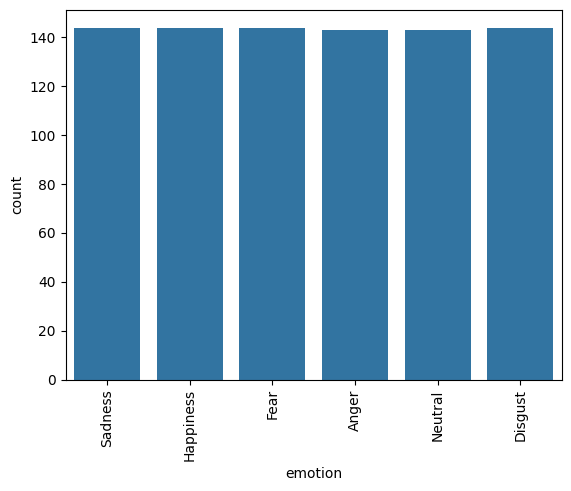

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xticks(rotation='vertical')
sns.countplot(x=df['emotion'])

## **Paso 1. Cargar audios**

In [ ]:
sampling_rate =16000

In [ ]:
import librosa

def load(data_path, sr=sampling_rate):
  dataset = {'audio':[], 'emotion':[]}
  # terar sobre cada archivo
  for i in range (len(data_path)):
    # Guardar la ruta y la emoción
    audio_path = data_path['audio'][i]
    emotion = data_path['emotion'][i]
    # cargar
    sound,sr = librosa.load(audio_path,sr=sr)
    dataset['audio'].append(sound)
    dataset['emotion'].append(emotion)
  return dataset

In [ ]:
dataset = load(df)

In [ ]:
print(len(dataset['emotion']))

862


**Revisión previa de longitud de audio**

In [ ]:
def get_average_length(ds):
  total_length = 0
  num_audios = len(ds['audio'])

  for audio in ds['audio']:
    audio_length = len(audio)
    total_length += audio_length

  average_length = total_length/num_audios
  return int(average_length)

In [ ]:
average_length = get_average_length(dataset)
print(f'Average length: ', average_length)

Average length:  11562


In [ ]:
contador = 0
for i,audio in enumerate(dataset['audio']):
  length = len(audio)
  if length > 23000:
    print(str(length) + ' --> ' + str((dataset['emotion'][i])) + ' --> ' + str(i))
    contador +=1
print(contador)

32331 --> Happiness --> 48
29697 --> Happiness --> 111
29697 --> Happiness --> 162
34912 --> Happiness --> 221
34939 --> Happiness --> 245
34377 --> Happiness --> 250
31613 --> Happiness --> 269
32722 --> Happiness --> 339
27765 --> Happiness --> 404
35036 --> Happiness --> 433
32378 --> Happiness --> 464
28242 --> Happiness --> 466
37308 --> Happiness --> 467
26682 --> Happiness --> 477
40595 --> Happiness --> 515
31533 --> Happiness --> 519
35877 --> Happiness --> 568
29489 --> Happiness --> 585
29697 --> Happiness --> 627
29615 --> Happiness --> 701
28519 --> Happiness --> 766
32165 --> Happiness --> 772
29182 --> Happiness --> 830
23


## **Paso 2. Separar por clases al dataset**

In [ ]:
def get_dataset_class(ds, target_label):
  dataset_class = {'audio':[], 'emotion':[]}

  for i,audio in enumerate(ds['audio']):
    if ds['emotion'][i] == target_label:
      dataset_class['audio'].append(audio)
      dataset_class['emotion'].append(target_label)

  print(str(target_label) + (' --> ') + str(len(dataset_class['emotion'])))
  return dataset_class

In [ ]:
label_emotions = ['Anger', 'Happiness', 'Disgust', 'Neutral', 'Sadness', 'Fear']
anger_ds = get_dataset_class(dataset, label_emotions[0])
happiness_ds = get_dataset_class(dataset, label_emotions[1])
disgust_ds = get_dataset_class(dataset, label_emotions[2])
neutral_ds = get_dataset_class(dataset, label_emotions[3])
sadness_ds = get_dataset_class(dataset, label_emotions[4])
fear_ds = get_dataset_class(dataset, label_emotions[5])

Anger --> 143
Happiness --> 144
Disgust --> 144
Neutral --> 143
Sadness --> 144
Fear --> 144


## **Paso 3. Data augmentation**

Se realizará un 100% de data augmentation divido en tres métodos. Es decir, 48 muestras extras por cada método en cada clase

**Display random samples**

In [ ]:
from IPython.display import Audio

def display_random_sample(ds, emotion='emotion', sampling_rate=sampling_rate):
  random_index = np.random.choice(len(ds['emotion']))
  print(f'índice: ', random_index)
  emotion = ds['emotion'][random_index]
  audio = ds['audio'][random_index]
  plt.figure(figsize=(8,4))
  librosa.display.waveshow(audio,sr=sampling_rate)
  plt.title(f'Waveform for emotion {emotion}')
  plt.xlabel('Tie (s)')
  plt.ylabel('Amplitude')
  plt.show()
  display(Audio(audio,rate=sampling_rate))

def display_sample(audio,title='Sample', sampling_rate=sampling_rate):
  plt.figure(figsize=(8,4))
  librosa.display.waveshow(audio,sr=sampling_rate)
  plt.title(title)
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  display(Audio(audio,rate=sampling_rate))

In [ ]:
import numpy as np

# agregar al dataset
def add_to_dataset(dsf):
  global dataset
  print('Antes:', len(dataset['audio']))
  for i in range(len(dsf['emotion'])):
    dataset['emotion'].append(dsf['emotion'][i])
    dataset['audio'].append(dsf['audio'][i])
  print('Después', len(dataset['audio']))

# 1. N O I S E   A D D I T I O N
# El ruido se basa en la desviación estándar del audio
def noise(ds, indices = (0,48), noise_factor=0.070):
  print('--- Noise addition ---')
  noise_dataset = {'audio':[],'emotion':[]}
  indices = np.arange(indices[0],indices[1],1)
  print(indices)
  emotions = [ds['emotion'][i] for i in indices]
  audios = [ds['audio'][i] for i in indices]

  for i in range(len(audios)):
    noise = np.random.normal(0,audios[i].std(), audios[i].size)
    augmented_signal = audios[i]+(noise*noise_factor)

    noise_dataset['emotion'].append(emotions[i])
    noise_dataset['audio'].append(augmented_signal)

  print(len(noise_dataset['audio']))
  display_sample(ds['audio'][indices[0]], title='Original')
  display_sample(noise_dataset['audio'][0], title='Noise addition')

  add_to_dataset(noise_dataset)

# 2. P I T C H   S H I F T I N G
def pitch_shift(ds,indices=(0,48),sr=sampling_rate,min_pitch=-4,max_pitch=4):
  print('--- Pitch-Shifting addition ---')
  ps_dataset = {'audio':[], 'emotion':[]}

  indices = np.arange(indices[0],indices[1],1)
  emotions = [ds['emotion'][i] for i in indices]
  audios = [ds['audio'][i] for i in indices]

  for i in range(len(audios)):
    pitch_shift_factor = np.random.uniform(min_pitch,max_pitch)
    pitch_shifted_audio = librosa.effects.pitch_shift(audios[i],sr=sr,
                                          n_steps=pitch_shift_factor)
    ps_dataset['audio'].append(pitch_shifted_audio)
    ps_dataset['emotion'].append(emotions[i])

  print(len(ps_dataset['audio']))
  display_sample(ds['audio'][indices[0]], title='Original')
  display_sample(ps_dataset['audio'][0], title='Noise addition')

  add_to_dataset(ps_dataset)

# 3. T I M E   S T R E T C H I N G
# Utilizaremos 'time_stretching con factor variable
def time_stretching(ds,indices=(0,48),sr=sampling_rate):
  print('--- Time Stretching addition ---')
  ts_dataset = {'audio':[],'emotion':[]}
  indices = np.arange(indices[0],indices[1],1)
  emotions = [ds['emotion'][i] for i in indices]
  audios = [ds['audio'][i] for i in indices]

  for i in range(len(audios)):
    stretch_factor = np.random.uniform(0.6,1.2)
    audio_stretch = librosa.effects.time_stretch(audios[i],rate=stretch_factor)

    ts_dataset['audio'].append(audio_stretch)
    ts_dataset['emotion'].append(emotions[i])

  display_sample(ds['audio'][indices[0]], title='Original')
  display_sample(ts_dataset['audio'][0], title='Noise addition')

  print(len(ts_dataset['audio']))
  add_to_dataset(ts_dataset)


In [ ]:
def data_augmentation(ds, num_audios, step, last_offset=False):
  noise(ds, indices = (0,step))
  pitch_shift(ds, indices=(step,step+step))

  if last_offset == True:
    indices = ((step+step-2),(step+(step*2))-1)
    print(indices)
    time_stretching(ds,indices=indices)
  else:
    time_stretching(ds, indices=(step+step, (step+(step*2))))

--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 862
Después 910
--- Pitch-Shifting addition ---
48


Antes: 910
Después 958
(94, 143)
--- Time Stretching addition ---


49
Antes: 958
Después 1007
--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 1007
Después 1055
--- Pitch-Shifting addition ---
48


Antes: 1055
Después 1103
--- Time Stretching addition ---


48
Antes: 1103
Después 1151
--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 1151
Después 1199
--- Pitch-Shifting addition ---
48


Antes: 1199
Después 1247
--- Time Stretching addition ---


48
Antes: 1247
Después 1295
--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 1295
Después 1343
--- Pitch-Shifting addition ---
48


Antes: 1343
Después 1391
(94, 143)
--- Time Stretching addition ---


49
Antes: 1391
Después 1440
--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 1440
Después 1488
--- Pitch-Shifting addition ---
48


Antes: 1488
Después 1536
--- Time Stretching addition ---


48
Antes: 1536
Después 1584
--- Noise addition ---
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
48


Antes: 1584
Después 1632
--- Pitch-Shifting addition ---
48


Antes: 1632
Después 1680
--- Time Stretching addition ---


48
Antes: 1680
Después 1728


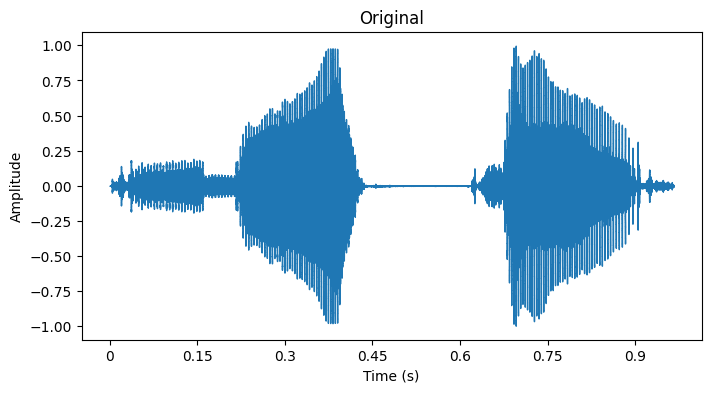

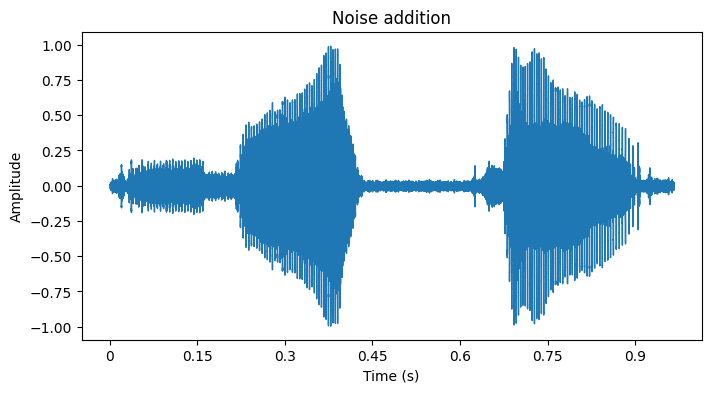

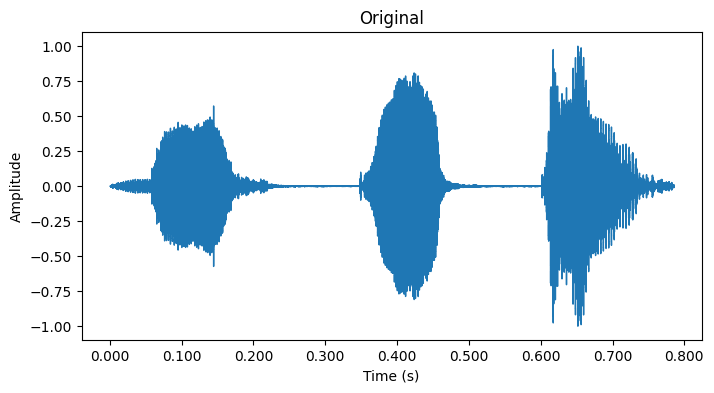

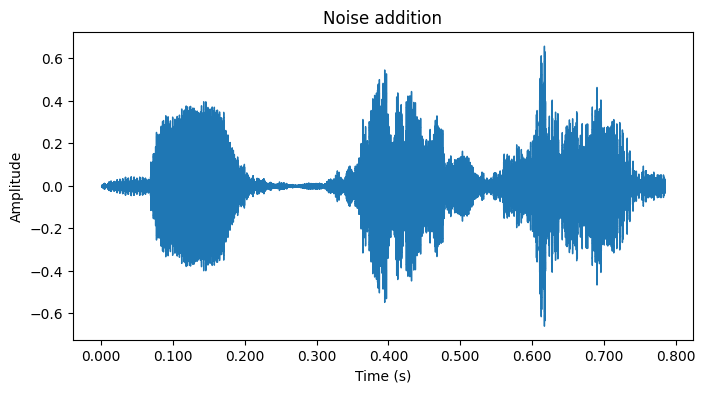

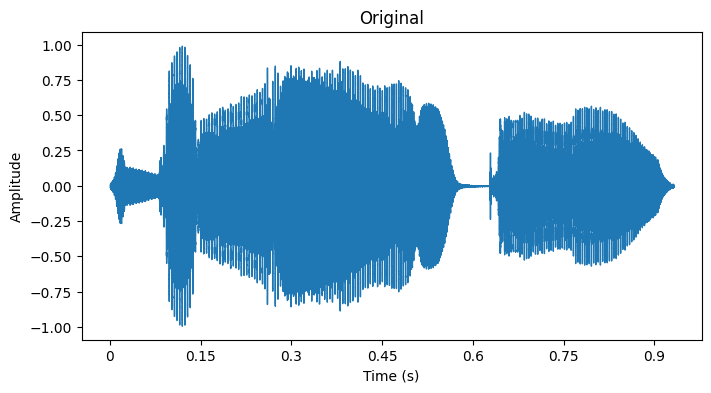

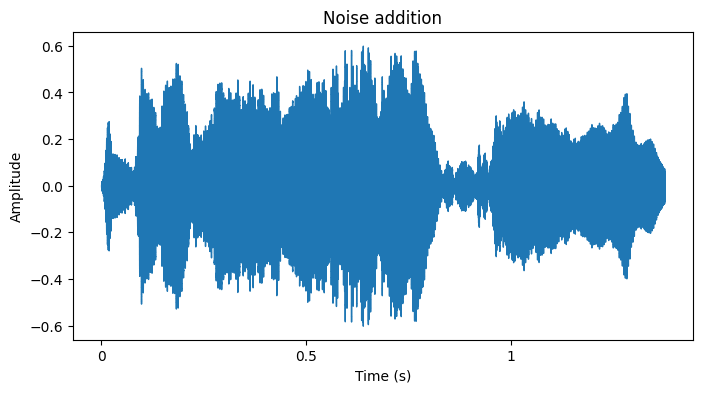

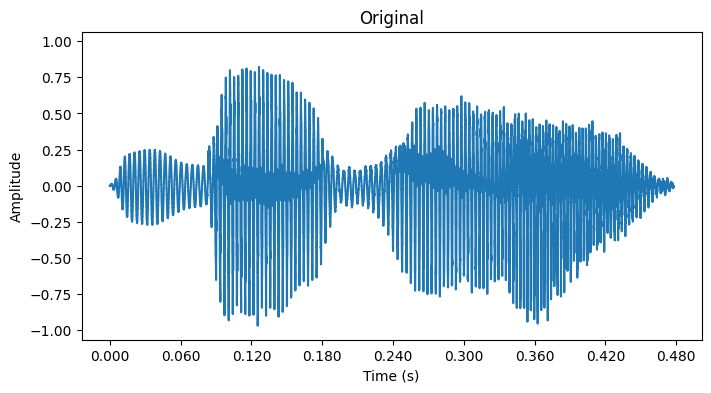

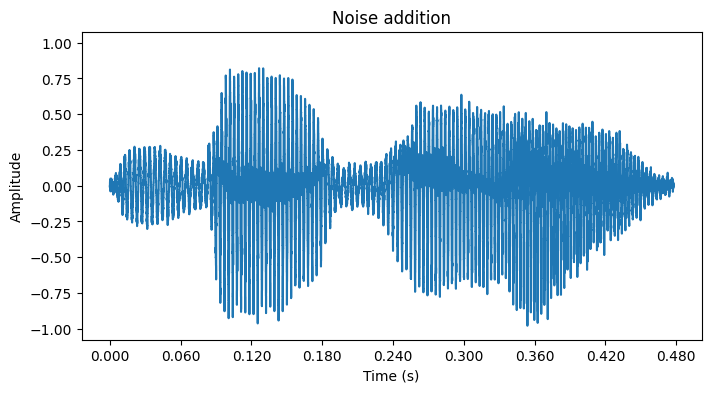

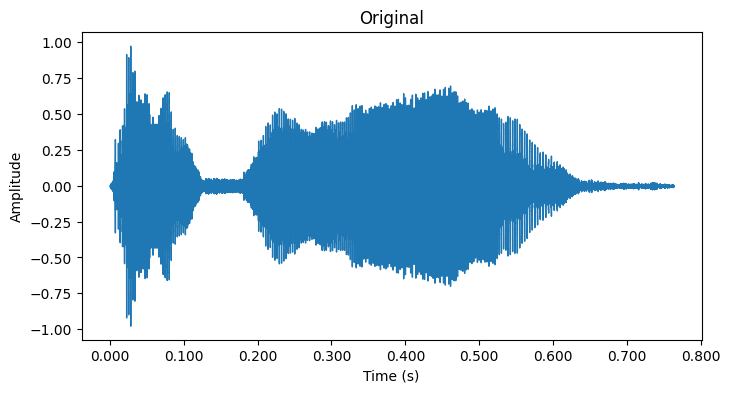

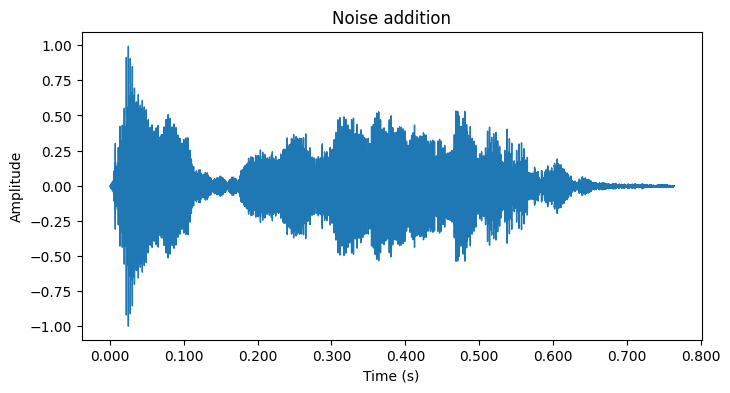

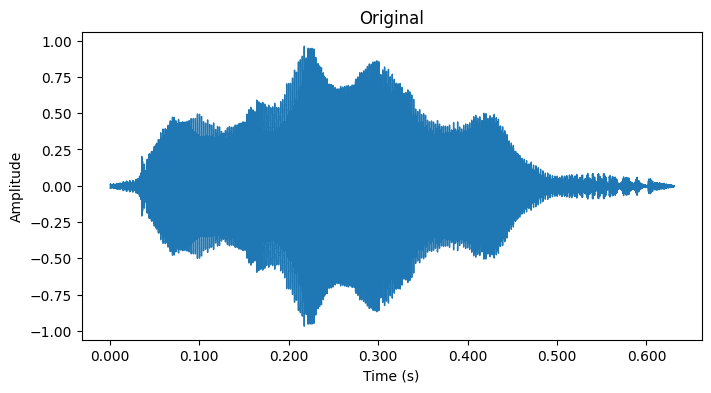

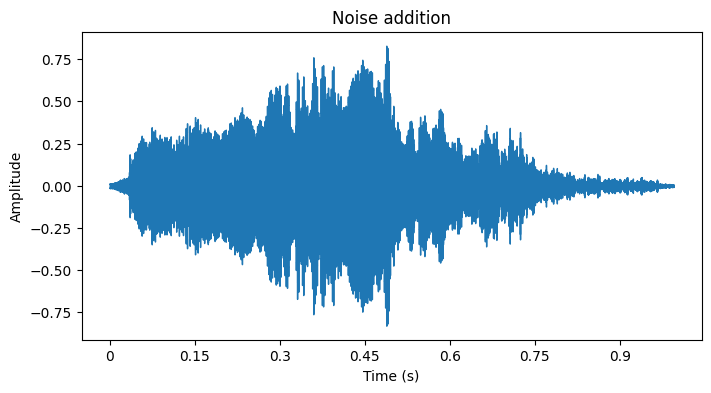

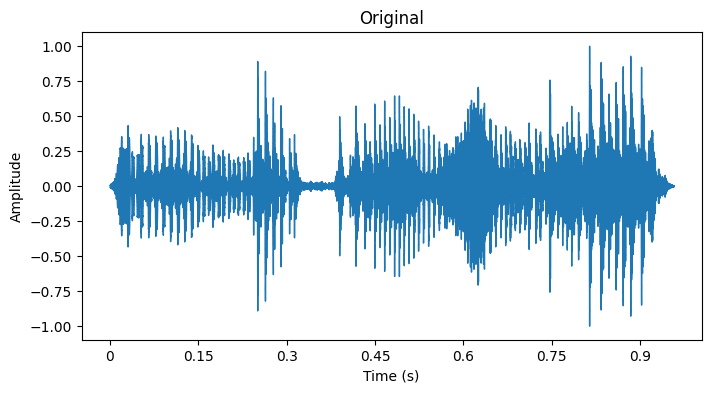

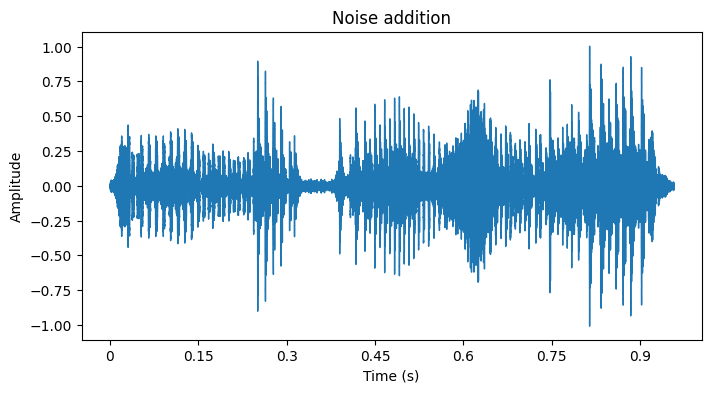

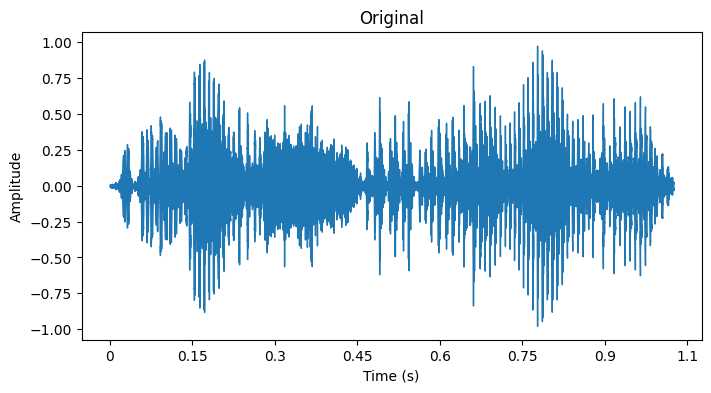

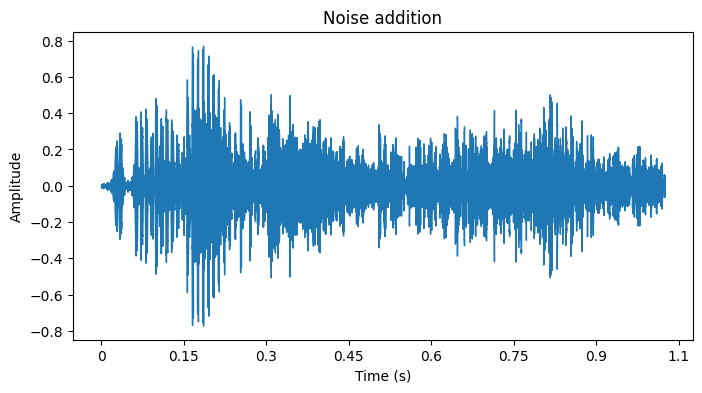

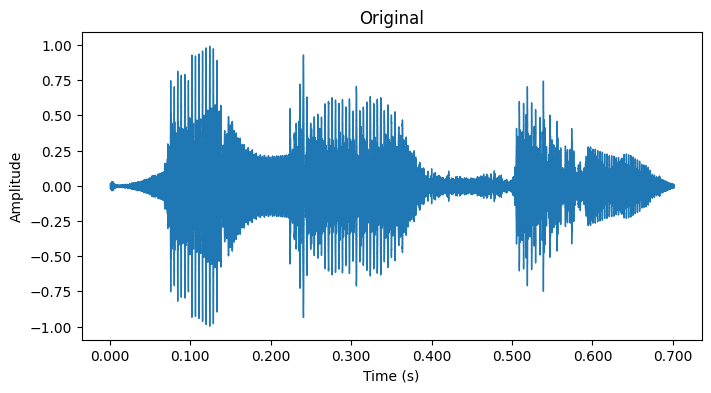

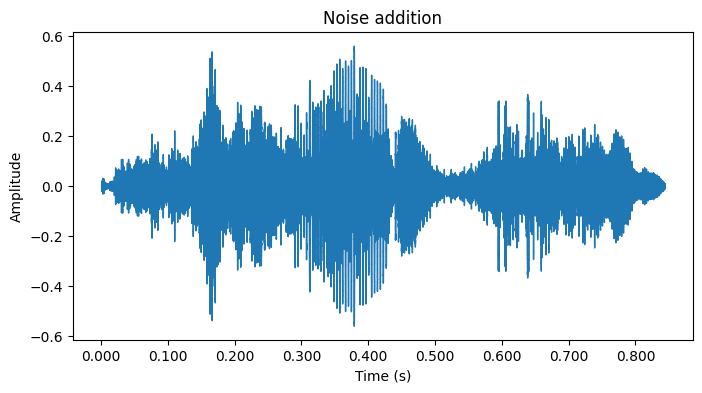

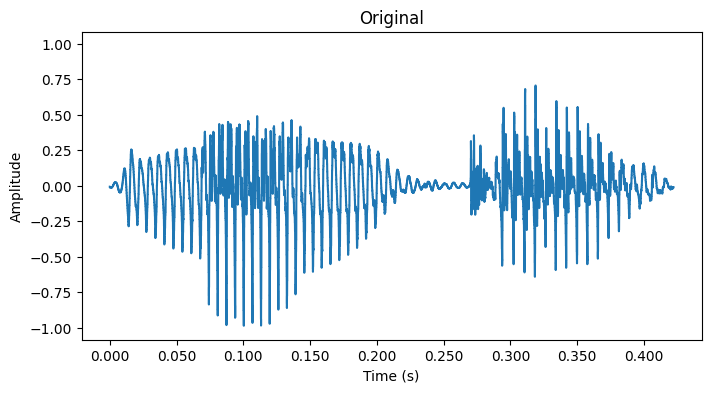

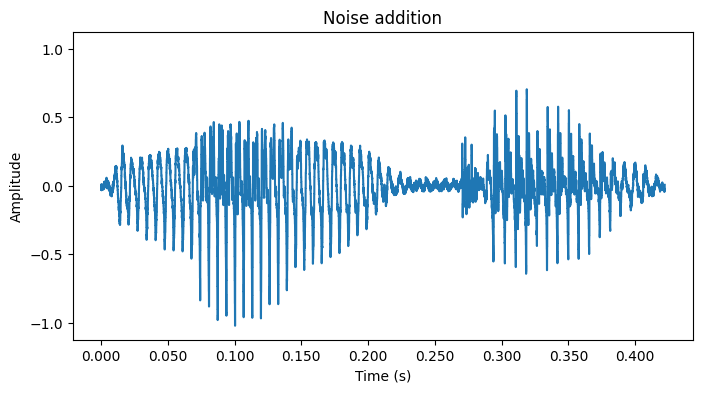

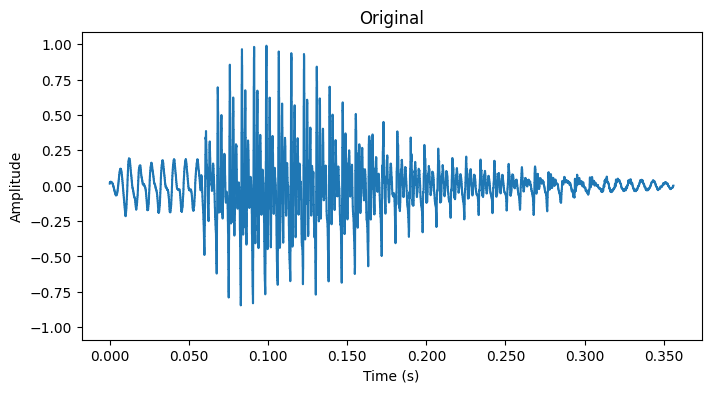

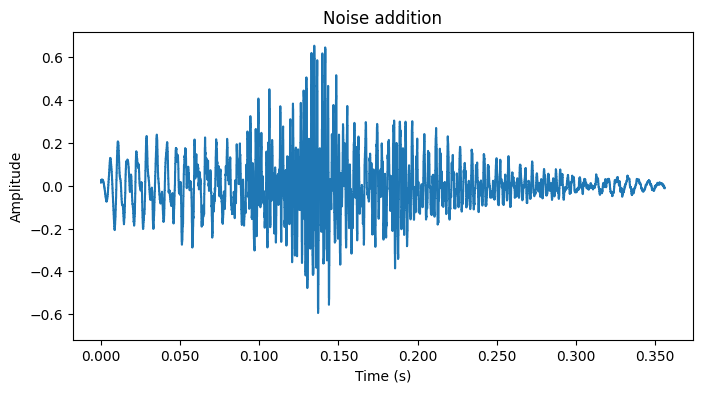

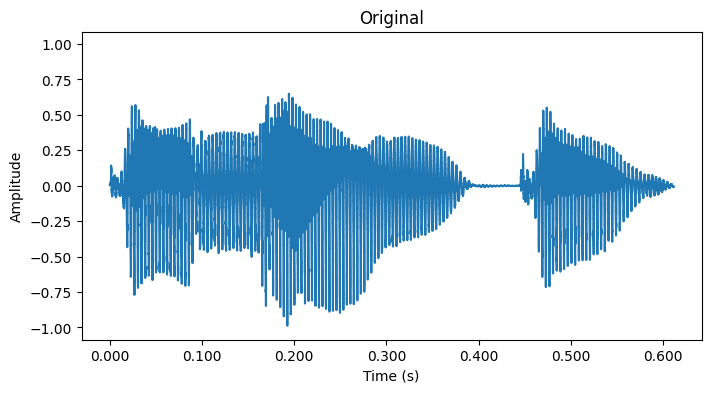

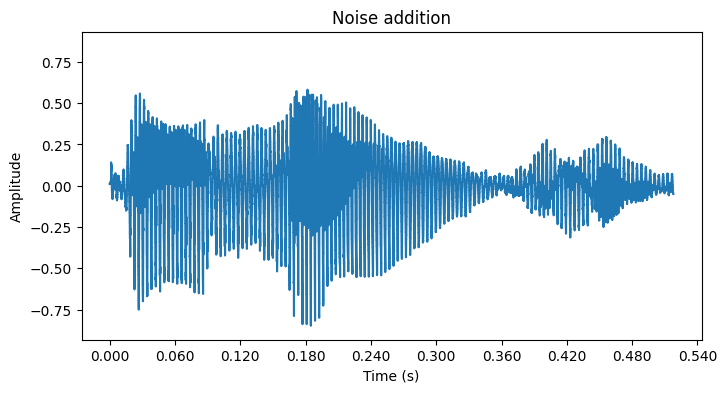

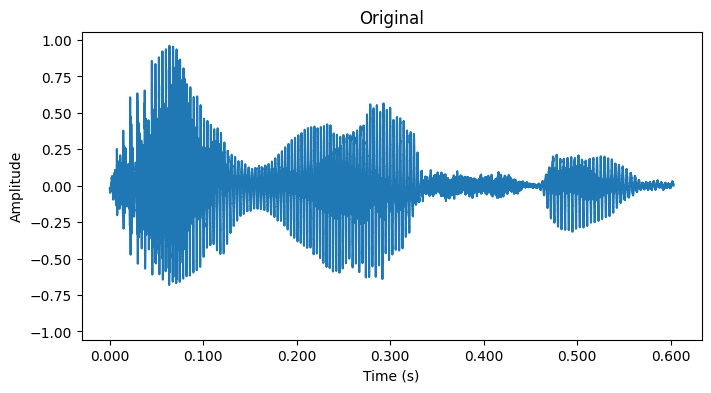

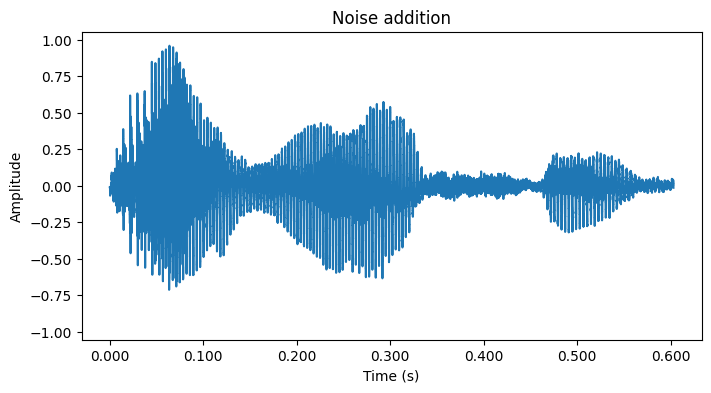

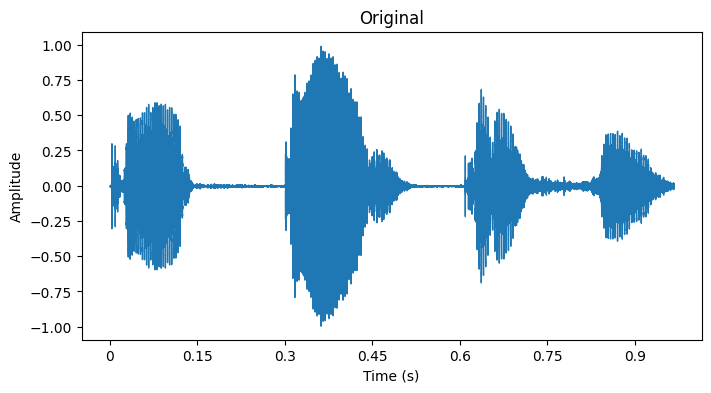

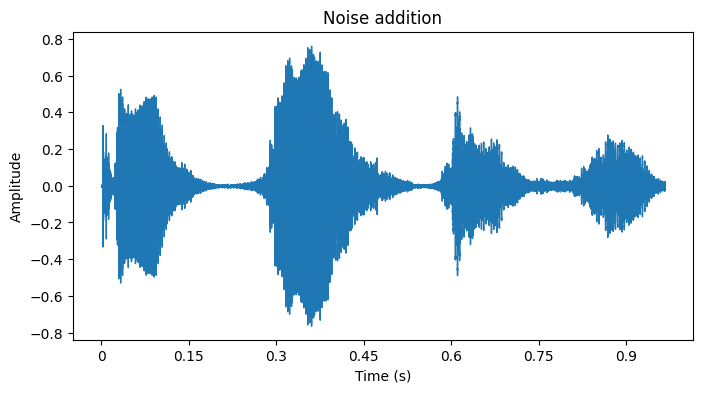

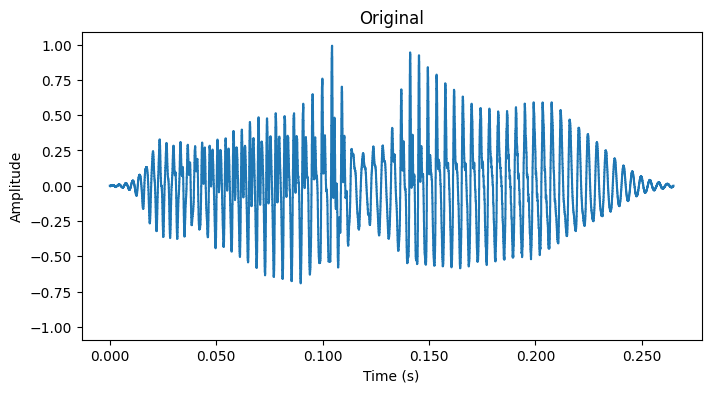

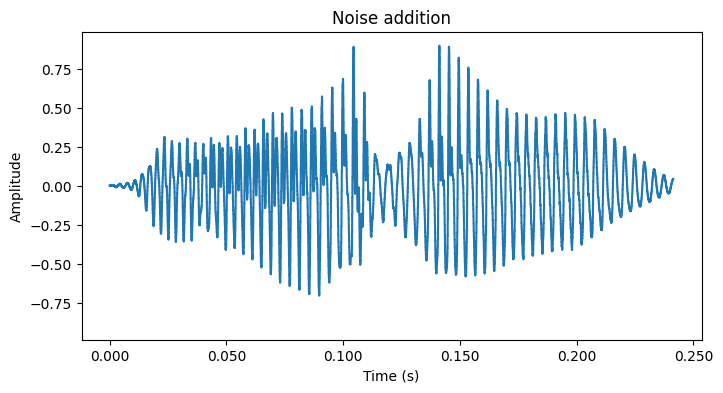

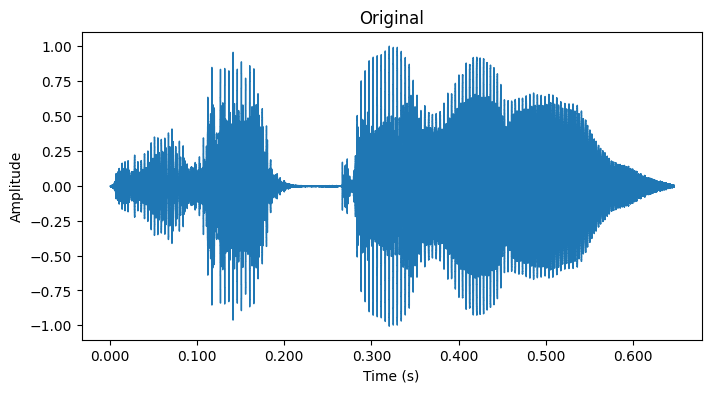

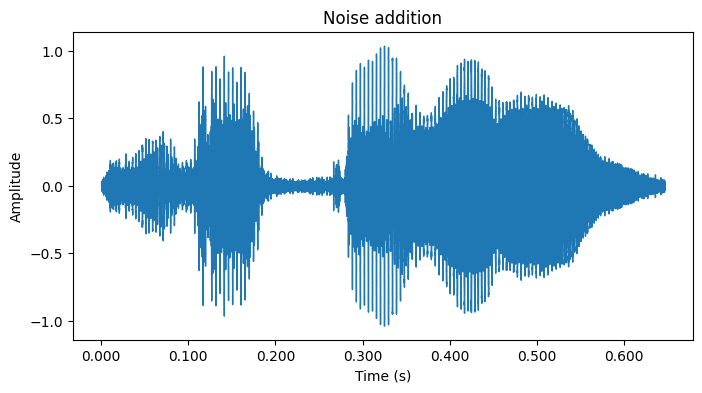

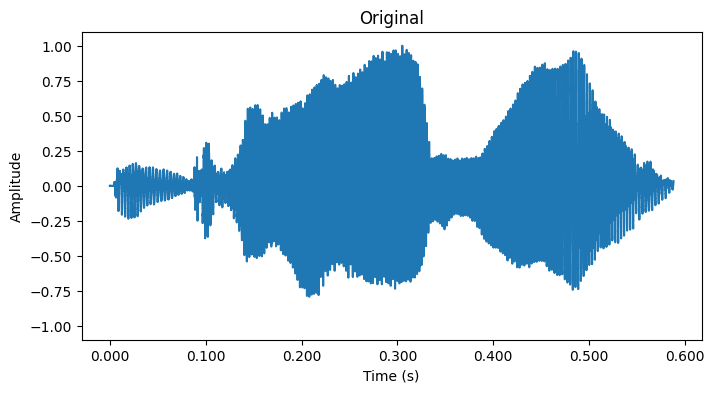

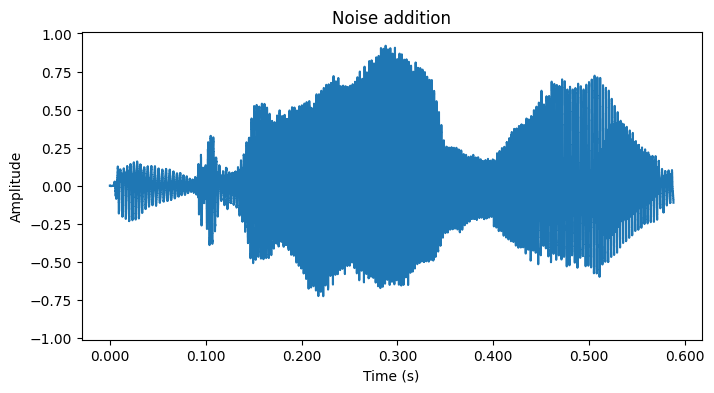

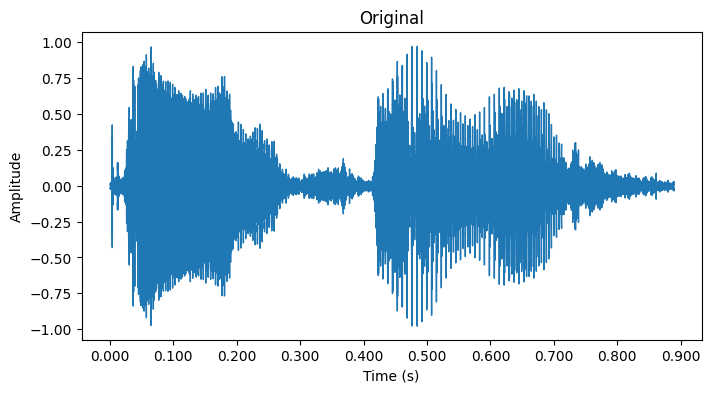

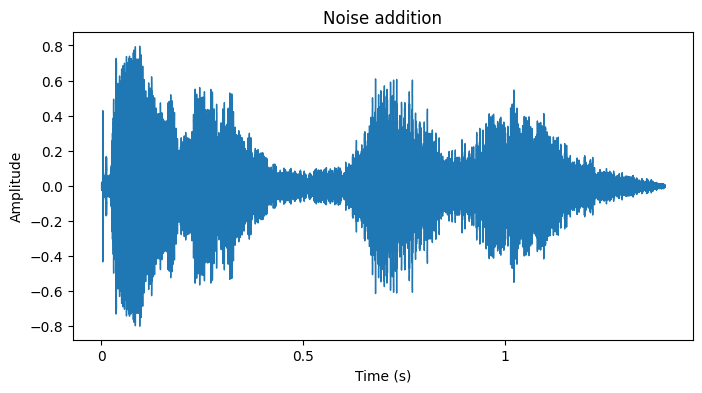

In [ ]:
data_augmentation(anger_ds,148,48, last_offset=True)
data_augmentation(happiness_ds,148,48)
data_augmentation(disgust_ds,148,48)
data_augmentation(neutral_ds,148,48, last_offset=True)
data_augmentation(sadness_ds,148,48)
data_augmentation(fear_ds,148,48)


<Axes: ylabel='count'>

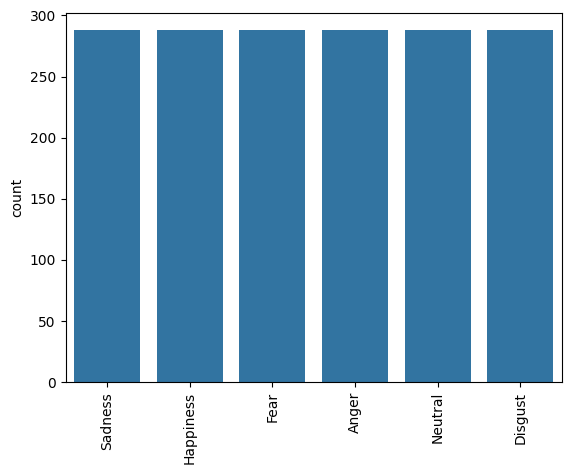

In [ ]:
plt.xticks(rotation='vertical')
sns.countplot(x=dataset['emotion'])

# **Método 1: Convolucional 1D**

### **Feature Extraction**

In [ ]:
def extract_features(data):
  # ZCR
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis=0)
  result = np.hstack((result,zcr)) #stacking horizontally

  # Chroma_stft
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T,axis=0)
  resutl = np.hstack((result,chroma_stft))

  # MFCC
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate).T, axis=0)
  result = np.hstack((result, mfcc))

  # Root Mean Square Value
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms))

  # MelSpectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
  result = np.hstack((result, mel))

  return result

def get_features(ds):
  X,Y = [],[]
  for audio,emotion in zip(ds['audio'],ds['emotion']):
    result = extract_features(audio)
    X.append(result)
    Y.append(emotion)

  new_df = pd.DataFrame(X)
  new_df['emotion'] = Y
  return new_df

In [ ]:
new_df = get_features(dataset)

In [ ]:
print(new_df.head())
new_df.shape

          0           1           2          3          4          5  \
0  0.161929 -155.401337   85.008636  -8.737379   1.767642 -22.310057   
1  0.085449 -134.335663   93.916061 -20.034382   9.895331 -10.222729   
2  0.057682 -141.473083   67.025558  -6.767663  43.503777 -35.007027   
3  0.041178 -187.924591  116.338112   2.647452  -7.556159  -1.765715   
4  0.078258 -154.519028  113.732796 -26.392962  -0.966244 -39.498028   

           6          7         8          9  ...       141       142  \
0  20.641827 -17.749058 -1.026744 -19.761400  ...  0.018530  0.012292   
1 -11.426279 -28.142336 -5.985528   2.118858  ...  0.006496  0.004350   
2  -7.033508 -25.962002 -0.123282 -29.864502  ...  0.007863  0.007610   
3   4.963568 -28.404846 -5.679131 -13.432174  ...  0.001652  0.001370   
4   3.357360 -32.812820 -3.134025 -13.098789  ...  0.001321  0.000884   

        143       144       145       146       147       148       149  \
0  0.018501  0.032758  0.023205  0.030090  0.033756  

(1728, 151)

### **Data Preparation**

In [ ]:
X = new_df.iloc[:,:-1].values
Y = new_df['emotion'].values

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.10 , shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1555, 150), (1555, 6), (173, 150), (173, 6))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1555, 150, 1), (1555, 6), (173, 150, 1), (173, 6))

## **MODELO 1. CNN1D**

In [ ]:
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D,Flatten,Dense, Dropout

model = Sequential()
model.add(Conv1D(128,3,activation='relu',input_shape=(x_train.shape[1],1)))
model.add(MaxPooling1D((1)))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer="adam",
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 148, 128)          512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 148, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 146, 256)          98560     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 146, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 144, 512)          393728    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 144, 512)          0

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


es=EarlyStopping(monitor='val_accuracy',patience=3)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
model_22=model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test),callbacks=[rlrp,es])

Epoch 1/50
13/13 [==============================] - 10s 216ms/step - loss: 3.9158 - accuracy: 0.2630 - val_loss: 1.5262 - val_accuracy: 0.3526 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 1s 100ms/step - loss: 1.5337 - accuracy: 0.3897 - val_loss: 1.4187 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 1s 98ms/step - loss: 1.3864 - accuracy: 0.4598 - val_loss: 1.1562 - val_accuracy: 0.6416 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 1s 98ms/step - loss: 1.2429 - accuracy: 0.5428 - val_loss: 1.0026 - val_accuracy: 0.6994 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 1s 98ms/step - loss: 1.1160 - accuracy: 0.5891 - val_loss: 0.9436 - val_accuracy: 0.7110 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 1s 97ms/step - loss: 0.9852 - accuracy: 0.6257 - val_loss: 0.7951 - val_accuracy: 0.7110 - lr: 0.0010
Epoch 7/50
13/13 [==============================] - 1s 98ms/step - loss: 

In [ ]:
num_epochs=17

6/6 [==============================] - 0s 15ms/step - loss: 0.4642 - accuracy: 0.8497
Testing accuracy of our model:  84.9711000919342 %


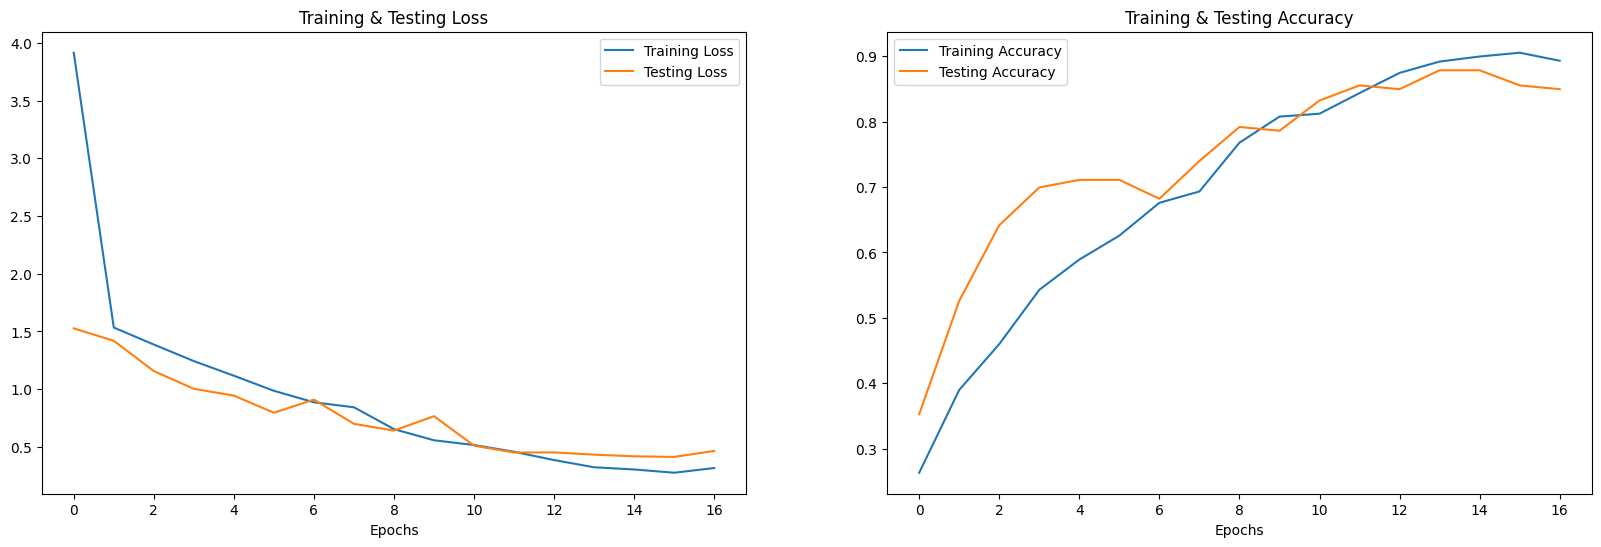

In [ ]:
print("Testing accuracy of our model: " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = model_22.history['accuracy']
train_loss = model_22.history['loss']
test_acc = model_22.history['val_accuracy']
test_loss = model_22.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

6/6 [==============================] - 0s 14ms/step


In [ ]:
c_df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
c_df['Predicted Labels'] = y_pred.flatten()
c_df['Actual Labels'] = y_test.flatten()

In [ ]:
c_df.sample(10)

,Predicted Labels,Actual Labels
130,Disgust,Disgust
68,Happiness,Happiness
121,Anger,Anger
13,Happiness,Happiness
4,Anger,Anger
152,Disgust,Disgust
59,Fear,Anger
34,Disgust,Disgust
23,Sadness,Sadness
69,Happiness,Happiness


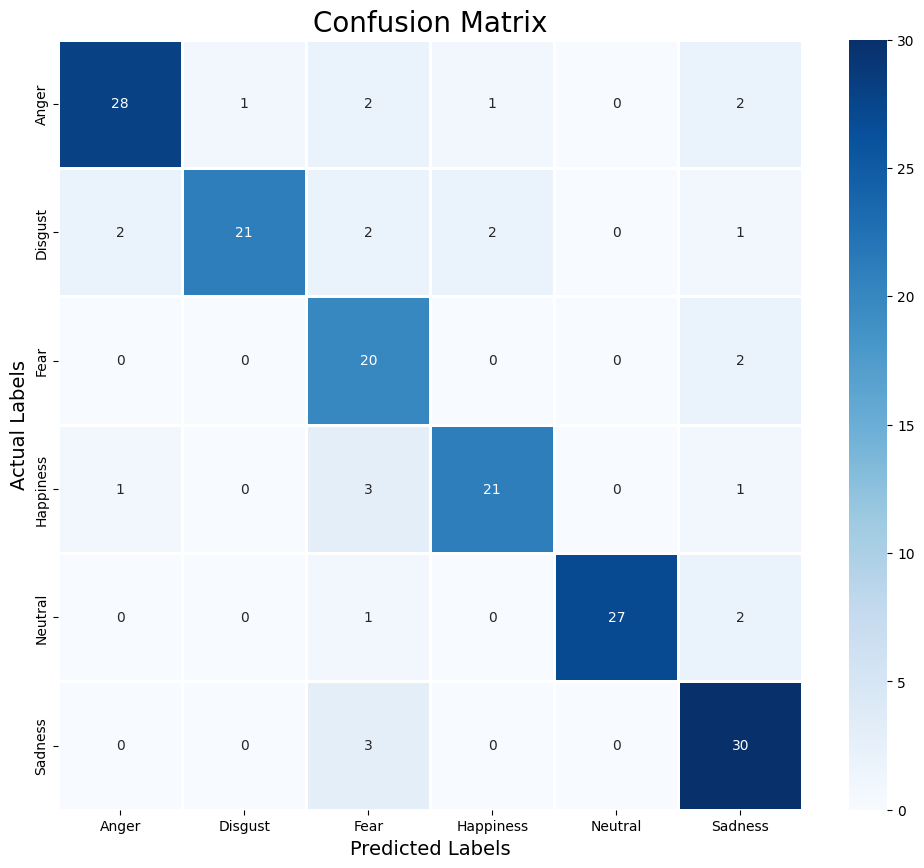

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Anger       0.90      0.82      0.86        34
     Disgust       0.95      0.75      0.84        28
        Fear       0.65      0.91      0.75        22
   Happiness       0.88      0.81      0.84        26
     Neutral       1.00      0.90      0.95        30
     Sadness       0.79      0.91      0.85        33

    accuracy                           0.85       173
   macro avg       0.86      0.85      0.85       173
weighted avg       0.87      0.85      0.85       173



In [ ]:
model.save('/drive/MyDrive/mesd_cnn1d.h5')

## **Paso 4. Normalizar tamaño de audios**

Dado que se trata de palabras, se normalizarán todos al tamaño máximo que existe.

In [ ]:
def get_average_length(ds):
  total_length = 0
  num_audios = len(ds['audio'])

  for audio in ds['audio']:
    audio_length = len(audio)
    total_length += audio_length

  average_length = total_length/num_audios
  return int(average_length)

In [ ]:
average_length = get_average_length(dataset)
print(f'Average length: ', average_length)

In [ ]:
def get_longer_audio(ds):
  lengths = [len(audio) for audio in ds['audio']]
  longer_length = max(lengths)
  return longer_length

In [ ]:
longer_length = get_longer_audio(dataset)
print(longer_length)

**Al parecer hay mucha desviación.**
Se tratará de obtener aquellos audios que sobrepasan la longitud media.

In [ ]:
for i,audio in enumerate(dataset['audio']):
  length = len(audio)
  if length > 20000:
    print(str(length) + ' --> ' + str((dataset['emotion'][i])))


In [ ]:
def fix_length(ds, target_length):
  fixed_dataset = {'audio':[], 'emotion':[]}

  for i, audio in enumerate(ds['audio']):
    audio_len = len(audio)

    padding_length = target_length - audio_len
    audio_padded = np.pad(audio,(0,padding_length))
    fixed_dataset['audio'].append(audio_padded)
    fixed_dataset['emotion'].append(dataset['emotion'][i])

  return fixed_dataset

In [ ]:
fixed_dataset = fix_length(dataset, longer_length)

In [ ]:
def check_audio_lengths(ds):
  lengths = [len(audio) for audio in ds['audio']]
  if len(set(lengths)) == 1:
    print(f'Todos los audios tiene longitud {lengths[0]}')
  else:
    print('Los audios tienen diferentes longitudes')

In [ ]:
check_audio_lengths(fixed_dataset)

## **Paso 5. Extracción de características**

In [ ]:
def feature_space_2D(ds, sampling_rate=sampling_rate, n_mels=128, n_fft=1569, hop_length=512):
  feature_space_2D = {'mel_spectrogram':[], 'emotions':[]}
  for i,audio, in enumerate(ds['audio']):
    mel_spec = librosa.feature.melspectrogram(y=audio,sr=sampling_rate, n_mels=n_mels,
                                              n_fft=n_fft, hop_length=hop_length)
    # Convert mel spectrogram to log scale
    mel_spec_db= librosa.power_to_db(mel_spec, ref=np.max)
    #mel_spec_3d = mel_spec_db.reshape(mel_spec_db.shape[0], mel_spec_db.shape[1],1)
    #feature_space_2D['mel_spectrogram].append(mel_spec_3d)
    feature_space_2D['mel_spectrogram'].append(mel_spec_db)
    feature_space_2D['emotions'].append(ds['emotion'][i])
  return feature_space_2D

In [ ]:
feature_space_2d_dataset = feature_space_2D(fixed_dataset)

In [ ]:
# Get the sahpes of the arrays
shapes = [arr.shape for arr in feature_space_2d_dataset['mel_spectrogram']]

# check if all shapes are equal
if all(shape == shapes[0] for shape in shapes):
  print(f'The arrays have the same number of elements {shapes[0]}')
else:
  print('The arrays have different numbers of elements')

In [ ]:
a = np.array(feature_space_2d_dataset['emotions'])
print(a.shape)

In [ ]:
len(feature_space_2d_dataset['mel_spectrogram'])

In [ ]:
def display_random_samples_spectrogram(feature_space_2D_dataset,n,sampling_rate=sampling_rate) :
  random_indices = np.random.choice(len(feature_space_2D_dataset["mel_spectrogram"]),n, replace=False)
  emotions = [feature_space_2D_dataset["emotions"][i] for i in random_indices]
  mel_spectrograms = [feature_space_2D_dataset["mel_spectrogram"][i] for i in random_indices]
  for i in range(len(mel_spectrograms)):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrograms[i], sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram - Emotion: {emotions[i]}")
    plt.show()

In [ ]:
display_random_samples_spectrogram(feature_space_2d_dataset,10)